# Feature-Based Explanations using Saliency Library

## Overview

This lab shows how to train a classification model on image data and use Saliency library to explain the model (feature attributions).

[Saliency](https://github.com/PAIR-code/saliency) is a framework-agnostic library for state-of-the-art saliency methods (XRAI, BlurIG, SmoothGrad, and more) for exlainability, developed by Google PAIR (People and AI Research) team.<br>
In this notebook, we will explore how to use Saliency for an image classification model written in TensorFlow Keras.


In this lab you will:
* Explore the dataset
* Build and train a custom image classification model
* Compute explanations using Saliency library
* Visualize feature attributions from Integrated Gradients and XRAI

## Setup

### Import libraries

Import the libraries for this tutorial.

In [1]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

In [2]:
import random

import matplotlib.image as mpimg
import numpy as np
import saliency.core as saliency
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib import pylab as P
from matplotlib import pyplot as plt

In [3]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION

GCS_PATTERN = "gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec"
DATA_PATH = f"gs://{BUCKET}/flowers/data"

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

Run the following cell to create your Cloud Storage bucket if it does not already exist.

In [ ]:
%%bash
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
   echo -e "Bucket gs://${BUCKET} already exists."

else
   echo "Creating a new GCS bucket."
   gsutil mb -l ${REGION} gs://${BUCKET}
   echo -e "\nHere are your current buckets:"
   gsutil ls
fi

## Explore the Dataset
The dataset used for this tutorial is the [flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). This section shows how to shuffle, split, and copy the files to your GCS bucket. 

### Load, split, and copy the dataset to your GCS bucket

In [5]:
TRAINING_DATA_PATH = DATA_PATH + "/training"
EVAL_DATA_PATH = DATA_PATH + "/validation"
VALIDATION_SPLIT = 0.2

# Split data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]

# Copy training files to GCS
for file in training_filenames:
    !gsutil -m cp $file $TRAINING_DATA_PATH/

# Copy eval files to GCS
for file in validation_filenames:
    !gsutil -m cp $file $EVAL_DATA_PATH/

Copying gs://flowers-public/tfrecords-jpeg-192x192-2/flowers09-230.tfrec...
/ [1/1 files][  6.0 MiB/  6.0 MiB] 100% Done                                    
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://flowers-public/tfrecords-jpeg-192x192-2/flowers10-230.tfrec...
/ [1/1 files][  5.6 MiB/  5.6 MiB] 100% Done                                    
Operation completed over 1 objects/5.6 MiB.                                      
Copying gs://flowers-public/tfrecords-jpeg-192x192-2/flowers02-230.tfrec...
/ [1/1 files][  5.7 MiB/  5.7 MiB] 100% Done                                    
Operation completed over 1 objects/5.7 MiB.                                      
Copying gs://flowers-public/tfrecords-jpeg-192x192-2/flowers06-230.tfrec...
/ [1/1 files][  5.7 MiB/  5.7 MiB] 100% Done                                    
Operation completed over 1 objects/5.7 MiB.                                      
Copying gs://flowers-public/tfrecords-jpeg-1

Run the following commands. You should see a number of .tfrec files in your GCS bucket at both gs://{BUCKET}/flowers/data/training and gs://{BUCKET}/flowers/data/validation

In [6]:
!gsutil ls -l $TRAINING_DATA_PATH

   6250983  2024-03-25T11:55:14Z  gs://takumiohym-sandbox/flowers/data/training/flowers00-230.tfrec
   6231074  2024-03-25T11:55:06Z  gs://takumiohym-sandbox/flowers/data/training/flowers01-230.tfrec
   5952336  2024-03-25T11:54:56Z  gs://takumiohym-sandbox/flowers/data/training/flowers02-230.tfrec
   6254378  2024-03-25T10:43:15Z  gs://takumiohym-sandbox/flowers/data/training/flowers03-230.tfrec
   6056727  2024-03-25T11:55:12Z  gs://takumiohym-sandbox/flowers/data/training/flowers04-230.tfrec
   6100076  2024-03-14T18:25:10Z  gs://takumiohym-sandbox/flowers/data/training/flowers05-230.tfrec
   5968916  2024-03-25T11:54:58Z  gs://takumiohym-sandbox/flowers/data/training/flowers06-230.tfrec
   6088244  2024-03-25T11:55:02Z  gs://takumiohym-sandbox/flowers/data/training/flowers07-230.tfrec
   6162742  2024-03-25T11:55:00Z  gs://takumiohym-sandbox/flowers/data/training/flowers08-230.tfrec
   6346261  2024-03-25T11:54:51Z  gs://takumiohym-sandbox/flowers/data/training/flowers09-230.tfrec


In [7]:
!gsutil ls -l $EVAL_DATA_PATH

   6250983  2024-03-14T15:40:09Z  gs://takumiohym-sandbox/flowers/data/validation/flowers00-230.tfrec
   6231074  2023-08-17T16:07:25Z  gs://takumiohym-sandbox/flowers/data/validation/flowers01-230.tfrec
   5952336  2023-11-06T12:07:39Z  gs://takumiohym-sandbox/flowers/data/validation/flowers02-230.tfrec
   6254378  2024-03-25T11:55:18Z  gs://takumiohym-sandbox/flowers/data/validation/flowers03-230.tfrec
   6056727  2024-03-14T15:40:07Z  gs://takumiohym-sandbox/flowers/data/validation/flowers04-230.tfrec
   6100076  2024-03-25T11:55:20Z  gs://takumiohym-sandbox/flowers/data/validation/flowers05-230.tfrec
   5968916  2023-08-18T11:55:39Z  gs://takumiohym-sandbox/flowers/data/validation/flowers06-230.tfrec
   6088244  2023-08-18T11:55:37Z  gs://takumiohym-sandbox/flowers/data/validation/flowers07-230.tfrec
   6162742  2024-03-14T15:40:05Z  gs://takumiohym-sandbox/flowers/data/validation/flowers08-230.tfrec
   6346261  2023-08-17T15:51:39Z  gs://takumiohym-sandbox/flowers/data/validation/

### Create ingest functions and visualize some of the examples
Define and execute helper functions to plot the images and corresponding labels.

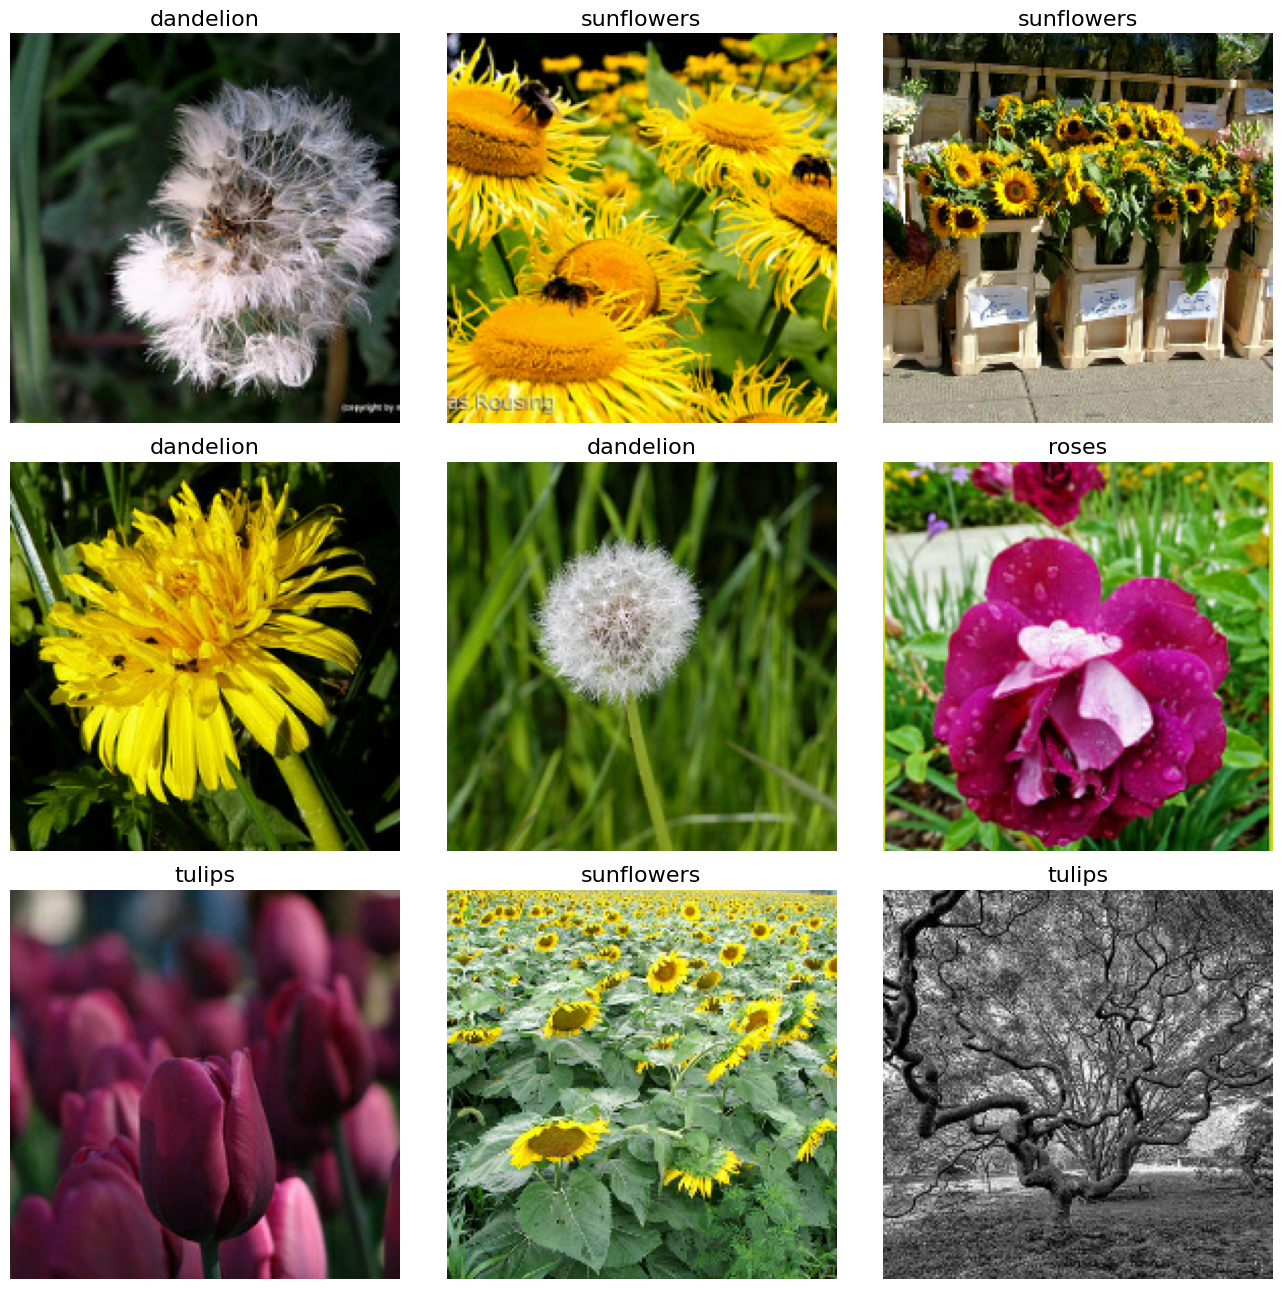

In [8]:
IMAGE_SIZE = [192, 192]
BATCH_SIZE = 32

# Do not change, maps to the labels in the data
CLASSES = [
    "daisy",
    "dandelion",
    "roses",
    "sunflowers",
    "tulips",
]


def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature(
            [], tf.string
        ),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = (
        tf.cast(image, tf.float32) / 255.0
    )  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    one_hot_class = tf.sparse.to_dense(example["one_hot_class"])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class


# Load tfrecords into tf.data.Dataset
def load_dataset(gcs_pattern):
    filenames = tf.io.gfile.glob(gcs_pattern + "/*")
    ds = tf.data.TFRecordDataset(filenames).map(read_tfrecord)
    return ds


# Converts N examples in dataset to numpy arrays
def dataset_to_numpy(dataset, N):
    numpy_images = []
    numpy_labels = []

    for images, labels in dataset.take(N):
        numpy_images.append(images.numpy())
        numpy_labels.append(labels.numpy())

    return numpy_images, numpy_labels


def display_one_image(image, title, subplot):
    plt.subplot(subplot)
    plt.axis("off")
    plt.imshow(image)
    plt.title(title, fontsize=16)
    return subplot + 1


def display_9_images_from_dataset(dataset):
    subplot = 331
    plt.figure(figsize=(13, 13))
    images, labels = dataset_to_numpy(dataset, 9)
    for i, image in enumerate(images):
        title = CLASSES[np.argmax(labels[i], axis=-1)]
        subplot = display_one_image(image, title, subplot)
        if i >= 8:
            break

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Display 9 examples from the dataset
ds = load_dataset(gcs_pattern=TRAINING_DATA_PATH)
display_9_images_from_dataset(ds)

## Build and Train a image classification model

This code contains the training logic. Here you build an application to ingest data from GCS and train an image classification model using [mobileNet](https://tfhub.dev/google/imagenet/mobilenet_v2_100_192/feature_vector/5) as a feature extractor, then sending it's output feature vector through a tf.keras.dense layer with 5 units and softmax activation (because there are 5 possible labels).

If you want to review the code and flows for image classification model with TensorFlow Keras, please review [this notebook](https://github.com/GoogleCloudPlatform/asl-ml-immersion/blob/master/notebooks/image_models/solutions/3_tf_hub_transfer_learning.ipynb).

In [9]:
IMAGE_SIZE = [192, 192]


def read_tfrecord(example):

    features = {
        "image": tf.io.FixedLenFeature(
            [], tf.string
        ),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = (
        tf.cast(image, tf.float32) / 255.0
    )  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    one_hot_class = tf.sparse.to_dense(example["one_hot_class"])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class


def load_dataset(gcs_pattern, batch_size=32, training=True):
    filenames = tf.io.gfile.glob(gcs_pattern)
    ds = tf.data.TFRecordDataset(filenames).map(read_tfrecord).batch(batch_size)
    if training:
        return ds.repeat()
    else:
        return ds


def build_model():
    # MobileNet model for feature extraction
    mobilenet_v2 = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/100-192-feature-vector/versions/2"
    feature_extractor_layer = hub.KerasLayer(
        mobilenet_v2, input_shape=[*IMAGE_SIZE, 3], trainable=False
    )

    # Instantiate model
    model = tf.keras.Sequential(
        [
            feature_extractor_layer,
            tf.keras.layers.Dense(5, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model


def train_and_evaluate(
    train_data_path,
    eval_data_path,
    output_dir,
    batch_size,
    num_epochs,
    train_examples,
):

    model = build_model()
    train_ds = load_dataset(gcs_pattern=train_data_path, batch_size=batch_size)
    eval_ds = load_dataset(gcs_pattern=eval_data_path, training=False)
    num_batches = batch_size * num_epochs
    steps_per_epoch = train_examples // num_batches

    history = model.fit(
        train_ds,
        validation_data=eval_ds,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
    )

    model.save(output_dir)

    print(f"Exported trained model to {output_dir}")
    return model

### Train the model locally 


In [10]:
model = train_and_evaluate(
    train_data_path=f"gs://{BUCKET}/flowers/data/training/*.tfrec",
    eval_data_path=f"gs://{BUCKET}/flowers/data/validation/*.tfrec",
    output_dir="model",
    batch_size=32,
    num_epochs=15,
    train_examples=15000,
)

Epoch 1/15
31/31 [==============================] - 58s 2s/step - loss: 1.2118 - accuracy: 0.5101 - val_loss: 0.7041 - val_accuracy: 0.7512
Epoch 2/15
31/31 [==============================] - 54s 2s/step - loss: 0.6005 - accuracy: 0.7903 - val_loss: 0.4907 - val_accuracy: 0.8332
Epoch 3/15
31/31 [==============================] - 54s 2s/step - loss: 0.4704 - accuracy: 0.8407 - val_loss: 0.4033 - val_accuracy: 0.8640
Epoch 4/15
31/31 [==============================] - 54s 2s/step - loss: 0.4150 - accuracy: 0.8554 - val_loss: 0.3476 - val_accuracy: 0.8866
Epoch 5/15
31/31 [==============================] - 54s 2s/step - loss: 0.3380 - accuracy: 0.8891 - val_loss: 0.3197 - val_accuracy: 0.8918
Epoch 6/15
31/31 [==============================] - 54s 2s/step - loss: 0.3210 - accuracy: 0.8942 - val_loss: 0.2850 - val_accuracy: 0.9084
Epoch 7/15
31/31 [==============================] - 54s 2s/step - loss: 0.2975 - accuracy: 0.8962 - val_loss: 0.2773 - val_accuracy: 0.9027
Epoch 8/15
31/31 [==

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


Exported trained model to model


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Check model prediction

Now that our image classification model has been trained. Let's choose a target image we want to explain, and check the prediction result.

In [12]:
eval_ds = load_dataset(
    gcs_pattern=f"gs://{BUCKET}/flowers/data/validation/*.tfrec",
    batch_size=1,
    training=False,
)

In [130]:
for d in eval_ds.shuffle(1000).take(1):
    image = d[0][0]
    result = model(tf.expand_dims(image, 0), 0)

prediction_class = tf.argmax(result, axis=-1).numpy()[0]

Here, we'll prepare several helper functions to aid in visualizing the image and explanations later.

In [131]:
def ShowImage(im, title="", ax=None):
    if ax is None:
        P.figure()
    P.axis("off")
    P.imshow(im)
    P.title(title)


def ShowGrayscaleImage(im, title="", ax=None):
    if ax is None:
        P.figure()
    P.axis("off")

    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)


def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis("off")
    P.imshow(im, cmap="inferno")
    P.title(title)

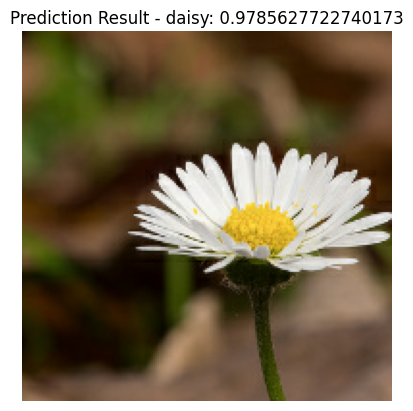

In [132]:
ShowImage(
    image,
    title=f"Prediction Result - {CLASSES[prediction_class]}: {result[0][prediction_class].numpy()}",
)

## Explanation with Saliency library
Now let's use [Saliency](https://github.com/PAIR-code/saliency) library to create explanations. We'll focus on two techniques: Integrated Gradients and XRAI, but the library support other saliency based explanation techniques. Check the repository page for more detail.

### Setup the `call_model_function`
Before we dive into explanation generation, we need to configure the `call_model_function`. 

`call_model_function` defines how we pass inputs to a given model and receive the outputs necessary to compute saliency masks. <br>
While we'll be using TensorFlow Keras, it's important to remember that the Saliency library is designed to work with various machine learning frameworks.

In [133]:
class_idx_str = "class_idx_str"

call_model_args = {class_idx_str: prediction_class}


def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx = call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        tape.watch(images)
        output_layer = model(images)
        output_layer = output_layer[:, target_class_idx]
        gradients = np.array(tape.gradient(output_layer, images))
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}

### Integrated Gradients

Let's start with the Integrated Gradients(IG) method. 
Integrated Gradients is an explainable AI technique described in the paper [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365). IG aims to explain the relationship between model's predictions in terms of its features, by integratig the gradients of model's output with respect to input features over interpolations between an original image and a baseline image.

Here, we'll utilize a black image as our baseline.

In [134]:
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(image.shape)

Now, let's generate an Integrated Gradients mask.

We can call `GetMask` method providing the following arguments:
- `x_value`: The target image.
- `call_model_function`: The `call_model_function` defined above.
- `call_model_args`: Relevant arguments for your `call_model_function`.
- `x_steps`: The number of interpolation steps for Integrated Gradients.
- `x_baseline`: The baseline image (A black image here)

Also, here we try `GetSmoothedMask` as well to get smoothed mask.

Keep in mind that these methods output 3D tensors. To visualize them, convert them to 2D grayscale using Saliency's convenient `VisualizeImageGrayscale` function.

In [135]:
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
    x_value=image.numpy(),
    call_model_function=call_model_function,
    call_model_args=call_model_args,
    x_steps=25,
    x_baseline=baseline,
)

smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
    x_value=image.numpy(),
    call_model_function=call_model_function,
    call_model_args=call_model_args,
    x_steps=25,
    x_baseline=baseline,
)

vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(
    vanilla_integrated_gradients_mask_3d
)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(
    smoothgrad_integrated_gradients_mask_3d
)

Let set up matplot lib figures and visualize the explanations.

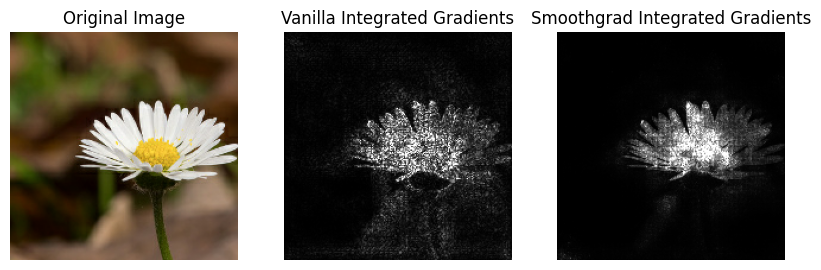

In [136]:
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowImage(image, title="Original Image", ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(
    vanilla_mask_grayscale,
    title="Vanilla Integrated Gradients",
    ax=P.subplot(ROWS, COLS, 2),
)
ShowGrayscaleImage(
    smoothgrad_mask_grayscale,
    title="Smoothgrad Integrated Gradients",
    ax=P.subplot(ROWS, COLS, 3),
)

### XRAI
Now let's check XRAI explanation.

XRAI is introduced in the paper [XRAI: Better Attributions Through Regions](https://arxiv.org/abs/1906.02825). It improves Integrated Gradients in many ways, including the integration with segmentation technique to provide more natural and intuitive explanation masks.

The `GetMask` is similar to the one of Integrated Gradients method.<br>
But here you don't need to add baseline, since XARI uses two white and black baseline images by default. <br>

Also, you can specify the step size by passing `extra_parameters=saliency.XRAIParameters(steps=<step size>)`. 
If not specified, the default step size `100` is used.

In [137]:
xrai_object = saliency.XRAI()

xrai_attributions = xrai_object.GetMask(
    x_value=image.numpy(),
    call_model_function=call_model_function,
    call_model_args=call_model_args,
    # extra_parameters=saliency.XRAIParameters(steps=25), # Optional
)

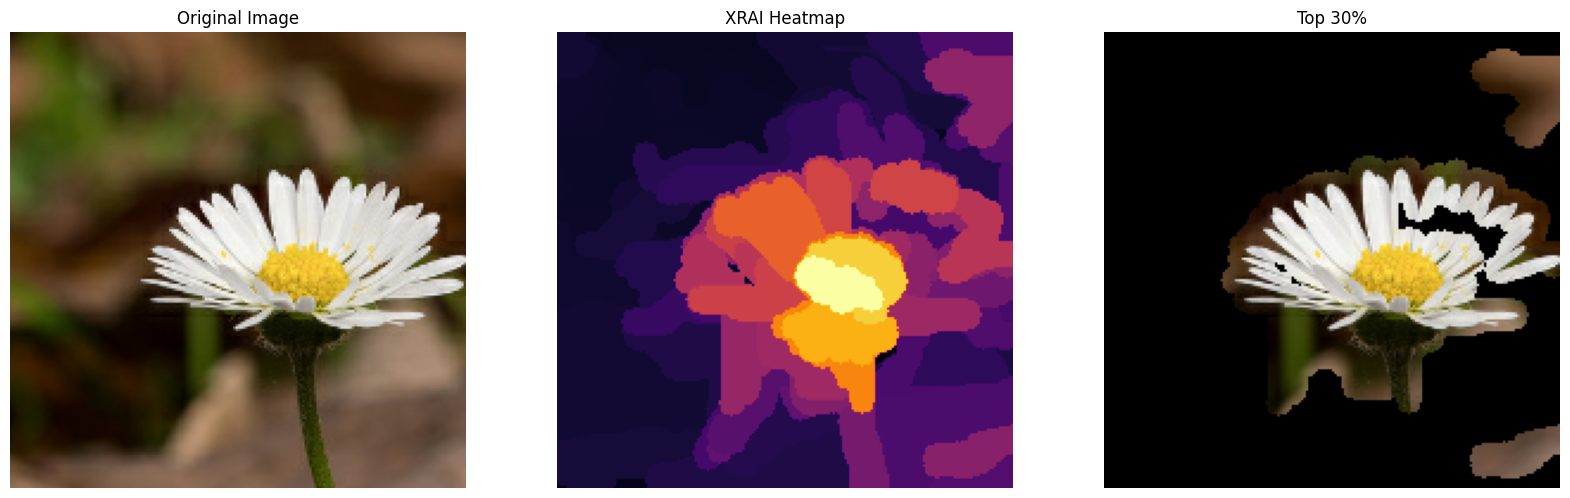

In [138]:
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(image, title="Original Image", ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(
    xrai_attributions, title="XRAI Heatmap", ax=P.subplot(ROWS, COLS, 2)
)

# Show most salient 30% of the image
mask = xrai_attributions >= np.percentile(xrai_attributions, 70)
im_mask = np.array(image)
im_mask[~mask] = 0
ShowImage(im_mask, title="Top 30%", ax=P.subplot(ROWS, COLS, 3))

## What's next?

To learn more about Saliency library and AI Explanations, check out the resources here.

* [Saliency](https://github.com/PAIR-code/saliency)
* [Integrated gradients paper](https://arxiv.org/abs/1703.01365)
* [XRAI paper](https://arxiv.org/abs/1906.02825)